In [2]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/addon.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/addon.zip
replace dataset-lite/val.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset-lite/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset-lite/test.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace dataset-lite/train.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: na
replace dataset-lite/label/test00015.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
# Imports



# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.transforms as tr
from model.change_detction_dataset import ChangeDetectionDataset, RandomFlip, RandomRot

# Models
from model.unet import Unet
from model.siamunet_conc import SiamUnet_conc
from model.siamunet_diff import SiamUnet_diff
from model.fresunet import FresUNet
from model.model import Model, ModelConfig

# Other
import numpy as np
from skimage import io

%matplotlib inline
from tqdm import tqdm as tqdm
import time
import warnings
from pprint import pprint


In [2]:
# Global Variables' Definitions
PATH_TO_DATASET = './dataset-lite/'
MODEL_TYPE = 0 # 0-FC-EF | 1-FC-Siam-diff | 2-FC-Siam-conc | 3-FresUNet
GPU_ENABLED = torch.cuda.is_available()
LOAD_TRAINED = False


#Cofniguration
DATA_AUG = True
BATCH_SIZE = 32
PATCH_SIDE = 96
N_EPOCHS = 100
NORMALISE_IMGS = True
TRAIN_STRIDE = int(PATCH_SIDE/2) - 1

In [5]:
# Dataset
if DATA_AUG:
    data_transform = tr.Compose([RandomFlip(), RandomRot()])
else:
    data_transform = None


train_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = True, stride = TRAIN_STRIDE, transform=data_transform)
weights = torch.FloatTensor(train_dataset.weights)
if GPU_ENABLED:
  print(f'GPU ENABLED')
  weights = weights.cuda()
  
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
test_dataset = ChangeDetectionDataset(PATH_TO_DATASET, train = False, stride = TRAIN_STRIDE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)



9999it [01:39, 100.68it/s]


GPU ENABLED


2999it [00:29, 101.33it/s]


In [6]:
# 0-FC-EF | 1-FC-Siam-diff | 2-FC-Siam-conc | 3-FresUNet
if MODEL_TYPE == 0:
    net, net_name = Unet(2*3, 2), 'FC-EF'
elif MODEL_TYPE == 1:
    net, net_name = SiamUnet_diff(3, 2), 'FC-Siam-diff'
elif MODEL_TYPE == 2:
    net, net_name = SiamUnet_conc(3, 2), 'FC-Siam-conc'
elif MODEL_TYPE == 3:
    net, net_name = FresUNet(2*3, 2), 'FresUNet'

if GPU_ENABLED:
    net.cuda()

criterion = nn.NLLLoss(weight=weights) # to be used with logsoftmax output

!nvidia-smi

Fri Apr 28 01:23:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    50W / 400W |   1011MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(net))

Number of trainable parameters: 1350578


In [8]:
model_config = ModelConfig(n_epochs=N_EPOCHS, gpu_enabled=GPU_ENABLED)
model = Model(
    model=net,
    model_name=net_name,
    config=model_config,
    train_dataset=train_dataset,
    train_loader=train_loader,
    test_dataset=test_dataset,
    criterion=criterion,
)

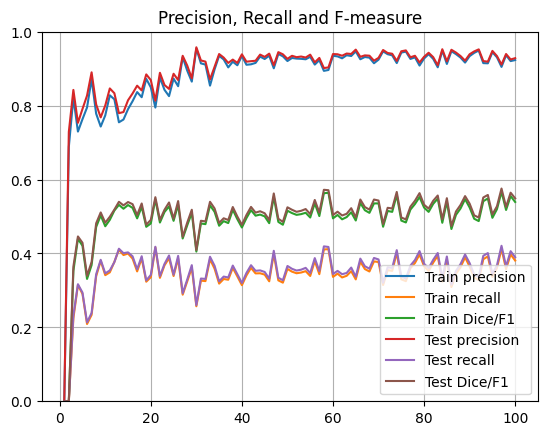

{'train_loss': 0.1944587081670761, 'train_accuracy': 91.66078836494837, 'train_nochange_accuracy': 0.9953455417815626, 'train_change_accuracy': 0.3808176086882023, 'test_loss': 0.19497764110565186, 'test_accuracy': 91.73919341817071, 'test_nochange_accuracy': 0.9955410577415215, 'test_change_accuracy': 0.38973416816808165}
Elapsed time:
21189.526612758636


NameError: ignored

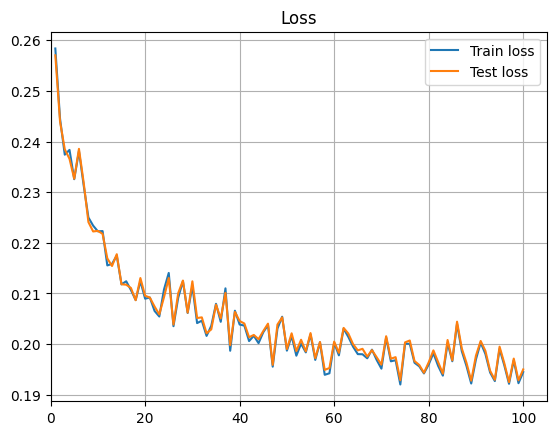

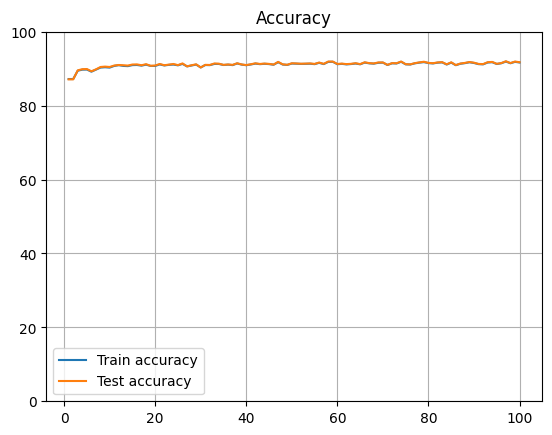

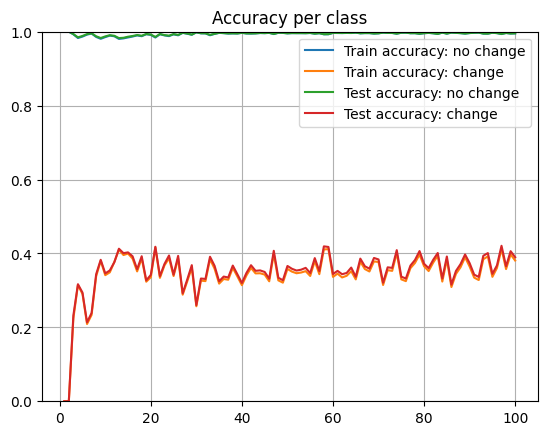

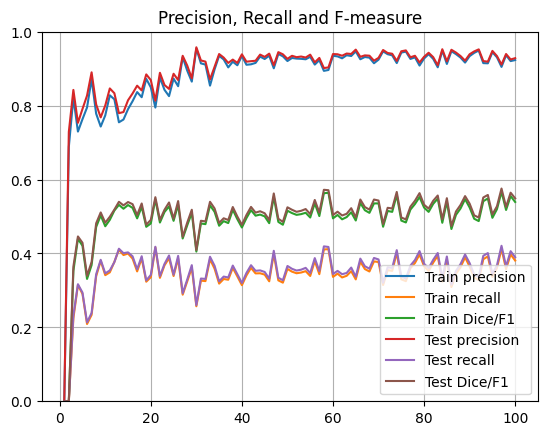

In [9]:
if LOAD_TRAINED:
    net.load_state_dict(torch.load('net_final.pth.tar'))
    print('LOAD OK')
else:
    t_start = time.time()
    out_dic = model.train()
    t_end = time.time()
    print(out_dic)
    print('Elapsed time:')
    print(t_end - t_start)
    plt.plot(out_dic)

In [10]:
if not LOAD_TRAINED:
    torch.save(model.model.state_dict(), 'net_final.pth.tar')
    print('SAVE OK')

SAVE OK


In [11]:
print(out_dic)

{'train_loss': 0.1944587081670761, 'train_accuracy': 91.66078836494837, 'train_nochange_accuracy': 0.9953455417815626, 'train_change_accuracy': 0.3808176086882023, 'test_loss': 0.19497764110565186, 'test_accuracy': 91.73919341817071, 'test_nochange_accuracy': 0.9955410577415215, 'test_change_accuracy': 0.38973416816808165}


In [ ]:
# Inference on test images
def save_test_results(dset):
    for idx, name in tqdm(dset.names.iterrows()):
        name = name[0]
        with warnings.catch_warnings():
            I1, I2, cm = dset.get_img(name)
            I1 = Variable(torch.unsqueeze(I1, 0).float())
            I2 = Variable(torch.unsqueeze(I2, 0).float())

            if GPU_ENABLED:
                I1 = I1.cuda()
                I2 = I2.cuda()

            out = net(I1, I2)
            _, predicted = torch.max(out.data, 1)
            I = np.stack((255*cm,255*np.squeeze(predicted.cpu().numpy()),255*cm),2)
            I = I.astype(np.uint8)
            io.imsave(f'{net_name}-{name}',I, check_contrast=False)

t_start = time.time()
save_test_results(test_dataset)
t_end = time.time()
print('Elapsed time: {}'.format(t_end - t_start))


In [ ]:
idx = list(range(0, len(train_dataset), 50))
valid_train_dataset = torch.utils.data.Subset(train_dataset, idx)
results_train = model.evaluate(train_dataset)
results_test = model.evaluate(test_dataset)

In [ ]:
print('Train Performance:')
print(results_train)
print('Test Performance:')
print(results_test)